In [3]:
# verify version
!python --version
!pip install --upgrade luxai_s2
!pip install gym==0.19
!cp -r ../input/lux-ai-season-2/* .

Python 3.7.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616821 sha256=5dacf72db2823e9eb18f561ed1a1f193fe4740dba283183a626d9d03fada89ab
  Stored in directory: /root/.cache/pip/wheels/d3/78/02/af51e23f21c31c0167d288296d764a22abb842ac6e8f52ebfa
  Created wheel for vec-noise: filename=vec_noise-1.1.4-cp37-cp37m-linux_x86_64.whl size=85837 sha256=947e17a624db24afc9bded768ee6fa033c0f2b28a23f1fef54e5272

In [4]:
%%writefile /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py
__version__ = ""
# this code above is used for Kaggle Notebooks
# You might not need to run this but if you get an attribute error about the gym package, run it

Overwriting /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py


In [18]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0e0d744d230b65c0dd83bf42998e6661f8c788777d862e586a8429c8df38412b
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=613c0f3cabe92e44f5c4a4541f545d48e0d573f53b26ad70ff953dc6beab1e1c
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built efficientnet-pytorch pretrainedmodels


## MAIN

In [5]:
import pandas as pd
import numpy as np
import requests
import json
import os
from luxai_s2.env import LuxAI_S2
import cv2
import time
import IPython # load the HTML replay

In [153]:
from itertools import chain

from lux.kit import process_obs, obs_to_game_state
from lux.config import EnvConfig


def get_unit_features(units, exclude, player, env_cfg):
    """
    - ours (1 light, 2 for heavy)
    - enemy (1 light, 2 for heavy)
    - power
    - cargo ice
    - cargo ore
    - cargo water
    - cargo metal
    """

    features = np.zeros((7, env_cfg.map_size, env_cfg.map_size))
    team_id = 0 if player == "player_0" else 1

    units = chain(units["player_0"].values(), units["player_1"].values())
    for unit in units:
        x, y = unit.pos
        if x, y == exclude:
            continue
        feats = [
            (1 if unit.unit_type == "LIGHT" else 2) * (unit.team_id == team_id),
            (1 if unit.unit_type == "LIGHT" else 2) * (unit.team_id != team_id),
            unit.power,
            unit.cargo.ice,
            unit.cargo.ore,
            unit.cargo.water,
            unit.cargo.metal,
        ]

        features[:, x, y] = feats
        
    return features


def get_factories_features(factories, player, env_cfg, game_state):
    """
    - ours
    - enemy
    - power
    - cargo ice
    - cargo ore
    - cargo water
    - cargo metal
    - water cost
    """

    features = np.zeros((8, env_cfg.map_size, env_cfg.map_size))
    team_id = 0 if player == "player_0" else 1

    factories = chain(factories["player_0"].values(), factories["player_1"].values())
    for unit in factories:
        x, y = unit.pos_slice
        feats = [
            (unit.team_id == team_id),
            (unit.team_id != team_id),
            unit.power,
            unit.cargo.ice,
            unit.cargo.ore,
            unit.cargo.water,
            unit.cargo.metal,
            unit.water_cost(game_state),
        ]

        features[:, x, y] = np.array(feats).reshape(-1, 1, 1)
        
    return features


def get_features(game_state, exclude, player):
    env_cfg = game_state.env_cfg
    return np.vstack(
        [
            game_state.board.rubble[np.newaxis],
            game_state.board.ice[np.newaxis],
            game_state.board.ore[np.newaxis],
            game_state.board.lichen[np.newaxis],
            np.ones((1, env_cfg.map_size, env_cfg.map_size)) * game_state.real_env_steps,
            np.ones((1, env_cfg.map_size, env_cfg.map_size)) * game_state.teams["player_0"].factories_to_place,
            np.ones((1, env_cfg.map_size, env_cfg.map_size)) * game_state.teams["player_0"].water,
            np.ones((1, env_cfg.map_size, env_cfg.map_size)) * game_state.teams["player_0"].metal,
            
#             np.ones((1, env_cfg.map_size, env_cfg.map_size)) * (game_state.real_env_steps % 50),  # day-night cycle
            get_factories_features(game_state.factories, exclude, player, env_cfg, game_state),
#             get_unit_features(game_state.units, player, env_cfg),
        ]
    )

SyntaxError: invalid syntax (95549526.py, line 24)

In [7]:
# from copy import deepcopy
# from lux.utils import my_turn_to_place_factory
    

# def process_match(match, team_name = "SiestaGuru"):
#     assert team_name in match["info"]["TeamNames"]
#     player = "player_0" if match["info"]["TeamNames"][0] == team_name else "player_1"
#     player_id = 0 if match["info"]["TeamNames"][0] == team_name else 1
    
#     env_cfg = EnvConfig.from_dict(deepcopy(match["configuration"]["env_cfg"]))

#     prev_obs = {}
#     for game_step in match["steps"]:
#         observation = game_step[0]["observation"]
#         actions = game_step[player_id]["action"]

#         step = observation["step"]
#         obs = json.loads(observation["obs"])

#         obs = process_obs(player, prev_obs, step, obs)
#         game_state = obs_to_game_state(step, env_cfg, obs)
#         if game_state.env_steps < 2:
#             pass
#         elif game_state.real_env_steps < 0:  # early setup
#             if my_turn_to_place_factory(game_state.teams[player].place_first, game_state.real_env_steps):
#                 yield get_features(game_state, player, env_cfg), actions, game_state
# #             pass
#         else:  # main game
#             return
#         prev_obs = obs

In [32]:
from torch.utils import data
import glob
import os
import pandas as pd



class ActionsDataset(data.IterableDataset):
    def __init__(self, fns):
        self.fns = fns

    def __iter__(self):
        pkls = (pd.read_pickle(fn) for fn in self.fns)
        flatten = (x for y in pkls for x in y)
        processed = (self._process(*x) for x in flatten)
        return processed
    
    def _process(self, game_state, actions, player):
        X = get_features(game_state, actions["spawn"], player)
        
        y_spawn = np.zeros(X.shape[1:])
        a, b = actions["spawn"]
        y_spawn[a, b] = 1
#         water = actions.get("water", 150)
#         metal = actions.get("water", 150)
        
        return X.astype("float32"), y_spawn[None, ...].astype("float32") #, water, metal


In [59]:
path = "/kaggle/input/luxai2-episode-scraper-match-downloader"
fns = glob.glob(os.path.join(path, "*.json"))
fns.remove("/kaggle/input/luxai2-episode-scraper-match-downloader/__output__.json")
fns_train = fns[: -1000]
fns_test = fns[-1000:]

ds_train = ActionsDataset(fns_train)
ds_test = ActionsDataset(fns_test)

In [60]:
BATCH_SIZE = 32
train_loader = data.DataLoader(ds_train, batch_size=BATCH_SIZE)
valid_loader = data.DataLoader(ds_test, batch_size=BATCH_SIZE)



In [30]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import segmentation_models_pytorch as smp

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [51]:
# Neural Network for Lux AI
class BasicConv2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, bn):
        super().__init__()
        self.conv = nn.Conv2d(
            input_dim, output_dim, 
            kernel_size=kernel_size, 
            padding=(kernel_size[0] // 2, kernel_size[1] // 2)
        )
        self.bn = nn.BatchNorm2d(output_dim) if bn else None

    def forward(self, x):
        h = self.conv(x)
        h = self.bn(h) if self.bn is not None else h
        return h


class LuxNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers, filters = 12, 32
        self.conv0 = BasicConv2d(16, filters, (3, 3), True)
        self.blocks = nn.ModuleList([BasicConv2d(filters, filters, (3, 3), True) for _ in range(layers)])
        self.convf = BasicConv2d(filters, 1, (3, 3), True)
        
#         self.head_p = nn.Linear(filters, 5, bias=False)

    def forward(self, x):
        h = F.relu_(self.conv0(x))
        for block in self.blocks:
            h = F.relu_(h + block(h))
#         h_head = (h * x[:,:1]).view(h.size(0), h.size(1), -1).sum(-1)
        p = self.convf(h)
        return p

In [47]:
# x = next(iter(train_loader))[0]
# x.shape
# model.model(x).shape

In [39]:
class Model(pl.LightningModule):

    def __init__(self,):
        super().__init__()
        self.model = LuxNet() # smp.Unet(
#             encoder_name="resnet34",
#             encoder_weights="imagenet",
#             in_channels=3,
#             classes=1,
#         )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def _step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

#         # Check that image dimensions are divisible by 32, 
#         # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
#         # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
#         # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
#         # and we will get an error trying to concat these features
#         h, w = image.shape[2:]
#         assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        assert mask.ndim == 4

        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def _epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        total_loss = 0
        iter_count = len(outputs)
    
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        metrics = {
            f"{stage}_loss": total_loss/iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self._epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self._epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self._epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [61]:
pl.seed_everything(2022)
model = Model()

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    mode='max',
    filename= "model_best",
    dirpath ='./',
    save_top_k = 1,
    save_weights_only=True
)

early_stop = EarlyStopping(monitor="valid_loss", min_delta=0.00, patience=20, verbose=True, mode="max")

In [62]:
from pytorch_lightning.loggers import CSVLogger

trainer = pl.Trainer(
    logger=CSVLogger(save_dir=f"logs/"),
    accelerator='gpu',
    devices=-1, 
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stop]
)

In [63]:
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [83]:
fns_test[8]

'/kaggle/input/luxai2-episode-scraper-match-downloader/46922360.json'

In [144]:
lst = pd.read_pickle(fns_test[8])

In [145]:
game_state, actions, player = lst[0]

In [146]:
feat = get_features(game_state, player)[None, ...].astype("float32")
feat = torch.Tensor(feat)
raw_res = model(feat).detach().numpy()[0, 0]
res = np.where(raw_res == raw_res[game_state.board.valid_spawns_mask].max())

In [147]:
game_state.board.valid_spawns_mask.sum()

1761

In [148]:
raw_res[game_state.board.valid_spawns_mask].shape

(1761,)

In [149]:
actions["spawn"]

[32, 14]

In [152]:
game_state.real_env_steps

-2

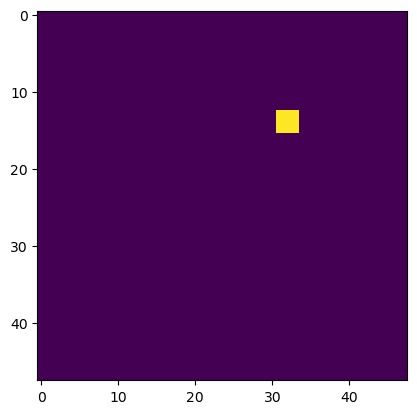

In [150]:
plt.imshow(get_features(game_state, player)[8].T)

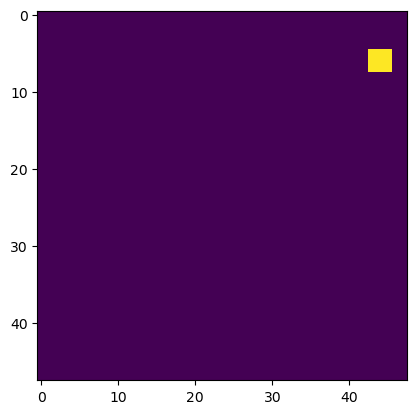

In [151]:
plt.imshow(get_features(game_state, player)[9].T)

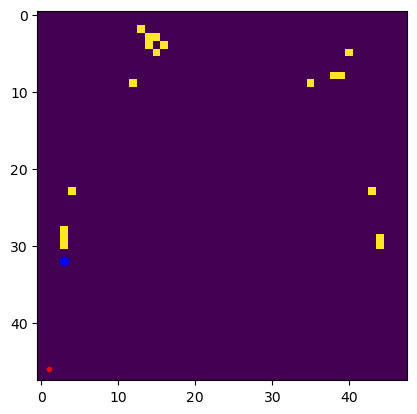

In [134]:
import matplotlib.pyplot as plt

plt.imshow(game_state.board.ice.T)
plt.scatter(actions["spawn"][0], actions["spawn"][1], color="blue")
plt.scatter(res[0], res[1], color="red", marker=".")

In [64]:
# x = next(iter(train_loader))[0]
# x.shape
# model.model(x).shape

'/kaggle/input/luxai2-episode-scraper-match-downloader/47171223.json'